In [ ]:
%load_ext rpy2.ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DETECCION DE FRAUDES CON TARJETAS DE CREDITO

In [ ]:
# DEFINIR RUTA
import os
os.chdir("/content/drive/MyDrive/Proyecto")

CARGA DE DATOS

In [ ]:
%%R
datos <- read.csv("card_transdata.csv")
str(datos)

'data.frame':	1000000 obs. of  8 variables:
 $ distance_from_home            : num  57.88 10.83 5.09 2.25 44.19 ...
 $ distance_from_last_transaction: num  0.311 0.176 0.805 5.6 0.566 ...
 $ ratio_to_median_purchase_price: num  1.946 1.294 0.428 0.363 2.223 ...
 $ repeat_retailer               : num  1 1 1 1 1 1 1 1 0 1 ...
 $ used_chip                     : num  1 0 0 1 1 0 0 0 0 0 ...
 $ used_pin_number               : num  0 0 0 0 0 0 0 1 0 0 ...
 $ online_order                  : num  0 0 1 1 1 0 1 0 0 1 ...
 $ fraud                         : num  0 0 0 0 0 0 0 0 0 0 ...


Limpieza y ajuste de datos

In [ ]:
%%R
# Variable dependiente como categorica
datos$fraud <- as.factor(datos$fraud)
str(datos)

# Validacion datos nulos
print("--------------------------------------------")
paste("Numero de valores NA: ", sum(is.na(datos)))

'data.frame':	1000000 obs. of  8 variables:
 $ distance_from_home            : num  57.88 10.83 5.09 2.25 44.19 ...
 $ distance_from_last_transaction: num  0.311 0.176 0.805 5.6 0.566 ...
 $ ratio_to_median_purchase_price: num  1.946 1.294 0.428 0.363 2.223 ...
 $ repeat_retailer               : num  1 1 1 1 1 1 1 1 0 1 ...
 $ used_chip                     : num  1 0 0 1 1 0 0 0 0 0 ...
 $ used_pin_number               : num  0 0 0 0 0 0 0 1 0 0 ...
 $ online_order                  : num  0 0 1 1 1 0 1 0 0 1 ...
 $ fraud                         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
[1] "--------------------------------------------"
[1] "Numero de valores NA:  0"


Observar la distribucion de la variable de respuesta

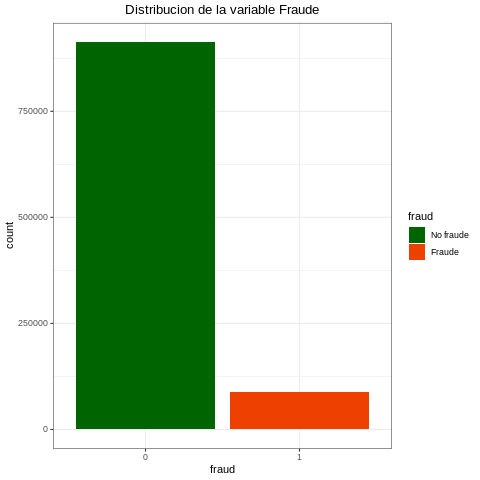

In [ ]:
%%R
library(ggplot2)

ggplot(data = datos, aes(x = fraud, y = ..count.. , fill = fraud)) +
  geom_bar() + 
  labs(title = "Distribucion de la variable Fraude") +
  scale_fill_manual(values = c("darkgreen", "orangered2"),
                    labels = c("No fraude", "Fraude")) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

In [ ]:
%%R
library(dplyr)
#Tabla de frecuencia variable de respuesta
table(datos$fraud)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





     0      1 
912597  87403 


In [ ]:
%%R
#Tabla de proporciones variable de respuesta
prop.table(table(datos$fraud)) %>% round(digits = 2 )


   0    1 
0.91 0.09 


Creación de nuestros conjuntos de entrenamiento y prueba para el modelo

In [ ]:
%%R
install.packages("caret")
require(caret)

In [ ]:
%%R
#Indices de observaciones de entrenamiento
set.seed(369)
train <- createDataPartition(y = datos$fraud, p = 0.8, list = FALSE,
                             times = 1)

#Datos de entrenamiento
datos_train <- datos[train, ]
print(prop.table(table(datos_train$fraud)) %>% round( digits = 2))
print("-------------------------------------------")
dim(datos_train)


   0    1 
0.91 0.09 
[1] "-------------------------------------------"
[1] 800001      8


In [ ]:
%%R
#Datos de test 
datos_test <- datos[-train, ]
print(prop.table(table(datos_test$fraud)) %>% round(digits = 2))
print("-------------------------------------------")
dim(datos_test)


   0    1 
0.91 0.09 
[1] "-------------------------------------------"
[1] 199999      8


## Arbol de clasificacion simple


In [ ]:
%%R
install.packages("tree")
library(tree)

In [ ]:
%%R
modelo_arbol = tree(fraud ~ ., data = datos_train)
summary(modelo_arbol)


Classification tree:
tree(formula = fraud ~ ., data = datos_train)
Variables actually used in tree construction:
[1] "ratio_to_median_purchase_price" "distance_from_home"            
[3] "distance_from_last_transaction" "online_order"                  
[5] "used_chip"                      "used_pin_number"               
Number of terminal nodes:  12 
Residual mean deviance:  0.02803 = 22420 / 8e+05 
Misclassification error rate: 0.00612 = 4896 / 800001 


El modelo utilizo 6 de las 7 varibles exogenas, con un numero final de 12 nodos terminales. El training error (observaciones mal clasificadas) es de 0.61%.

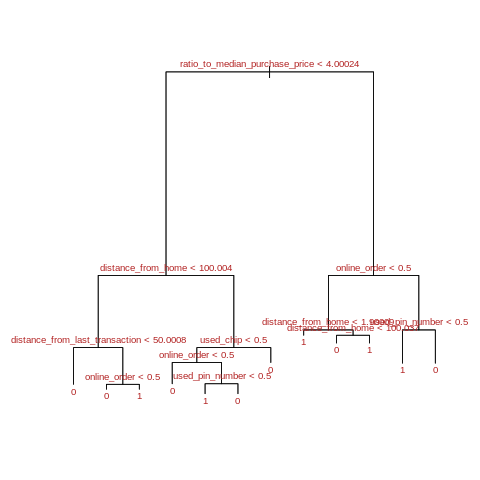

In [ ]:
%%R
# Representacion grafica del arbol
plot(modelo_arbol)
text(modelo_arbol, splits = TRUE, pretty = 0,
     cex = 0.8, col = "firebrick")

In [ ]:
%%R
modelo_arbol

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 800001 474400.0 0 ( 0.912596 0.087404 )  
   2) ratio_to_median_purchase_price < 4.00024 717364 167400.0 0 ( 0.975063 0.024937 )  
     4) distance_from_home < 100.004 681594  49330.0 0 ( 0.994096 0.005904 )  
       8) distance_from_last_transaction < 50.0008 671473      0.0 0 ( 1.000000 0.000000 ) *
       9) distance_from_last_transaction > 50.0008 10121  13600.0 0 ( 0.602411 0.397589 )  
        18) online_order < 0.5 3535      0.0 0 ( 1.000000 0.000000 ) *
        19) online_order > 0.5 6586   8803.0 1 ( 0.389007 0.610993 ) *
     5) distance_from_home > 100.004 35770  47770.0 0 ( 0.612385 0.387615 )  
      10) used_chip < 0.5 23305  31580.0 1 ( 0.411843 0.588157 )  
        20) online_order < 0.5 8236   1228.0 0 ( 0.985794 0.014206 ) *
        21) online_order > 0.5 15069   9674.0 1 ( 0.098149 0.901851 )  
          42) used_pin_number < 0.5 13590      0.0 1 ( 0.000000 1.000000 ) *
          43) use

In [ ]:
%%R
# Evaluacion del modelo - Predicciones datos test
predicciones <- predict(modelo_arbol, datos_test, type = "class")
confusionMatrix(predicciones, datos_test[,8])

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 181463    217
         1   1056  17263
                                         
               Accuracy : 0.9936         
                 95% CI : (0.9933, 0.994)
    No Information Rate : 0.9126         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9609         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9942         
            Specificity : 0.9876         
         Pos Pred Value : 0.9988         
         Neg Pred Value : 0.9424         
             Prevalence : 0.9126         
         Detection Rate : 0.9073         
   Detection Prevalence : 0.9084         
      Balanced Accuracy : 0.9909         
                                         
       'Positive' Class : 0              
                                

El modelo tiene presicion del 99.36%

**Para fines de tratar de simplificar el modelo y evitar overfitting; ademas de intentar mejorar las predicciones, aplicamos la poda del arbol**

In [ ]:
%%R
cv_arboles <- cv.tree(modelo_arbol, K = 10, FUN = prune.misclass)
cv_arboles

$size
[1] 12 10  8  7  4  3  1

$dev
[1]  4903  6362  8096  9575 21685 26677 69923

$k
[1]    -Inf   731.0   868.0  1479.0  4037.0  4992.0 21623.5

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"


La deviance corresponde al error de clasificacion

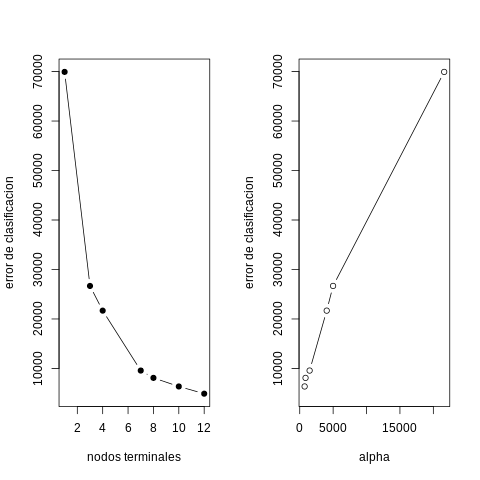

In [ ]:
%%R
par(mfrow = c(1,2))
#Cost complexity prunnig
plot(cv_arboles$size, cv_arboles$dev, xlab = "nodos terminales",
     ylab = "error de clasificacion", type = "b", pch = 19)
plot(x = cv_arboles$k, y = cv_arboles$dev, xlab = "alpha",
     ylab = "error de clasificacion", type = "b")

La reduccion de error de 7 a 12 nodos es notable, intentaremos probar el modelo con 7 nodos tratando de simplificar el modelo 

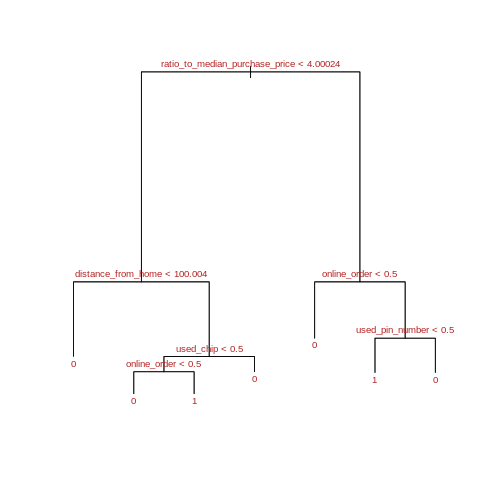

In [ ]:
%%R
#Poda del arbol a 7 nodos terminales
modelo_arbolPodado <- prune.misclass(tree = modelo_arbol, best = 7)

par(mfrow = c(1,1))
plot(x = modelo_arbolPodado, type = "proportional")
text(modelo_arbolPodado, splits = TRUE, pretty = 0,
     cex = 0.8, col = "firebrick")

In [ ]:
%%R
#Evaluacion del modelo
predicciones <- predict(modelo_arbolPodado, newdata = datos_test, 
                        type = "class")
confusionMatrix(predicciones, datos_test[,8])

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 182138   2064
         1    381  15416
                                          
               Accuracy : 0.9878          
                 95% CI : (0.9873, 0.9883)
    No Information Rate : 0.9126          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9199          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9979          
            Specificity : 0.8819          
         Pos Pred Value : 0.9888          
         Neg Pred Value : 0.9759          
             Prevalence : 0.9126          
         Detection Rate : 0.9107          
   Detection Prevalence : 0.9210          
      Balanced Accuracy : 0.9399          
                                          
       'Positive' Class : 0               
            

Con 12 nodos la presicion es de 99.36% con un Kappa de 96.09%

Y con 7 nodos la presicion es de 98.78% con un Kappa de 91.99%

El simplificar el arbol tiene un costo de 0.58%, que parece no tan severo.

# Método de bagging o bootstrap aggregation

Es un procedimiento utilizado para reducir la varianza de un método de aprendizaje estadístico.

**Clasificacion**
Dada una observación de test, podemos obtener la clase predicha por cada uno de los B árboles, y escoger como predicción final para dicha observación la clase más común de entre las B predicciones (predicción de cada árbol). El número de árboles (B) a crear no es un parámetro crítico a la hora de aplicar bagging(usaremos un número lo suficientemente alto como para alcanzar la estabilización en la reducción del test error - n, no afecta riesgo de overfitting).


In [ ]:
%%R
install.packages("randomForest")
library(randomForest)

In [ ]:
%%R
install.packages("ipred")
library(ipred)

In [ ]:
%%R
bagging <- bagging(fraud ~ ., data = datos_train)
bagging


Bagging classification trees with 25 bootstrap replications 

Call: bagging.data.frame(formula = fraud ~ ., data = datos_train)




In [ ]:
%%R
predicciones_bag <- predict(bagging, datos_test)
confusionMatrix(predicciones_bag, datos_test[,8])

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 182519      4
         1      0  17476
                                     
               Accuracy : 1          
                 95% CI : (0.9999, 1)
    No Information Rate : 0.9126     
    P-Value [Acc > NIR] : <2e-16     
                                     
                  Kappa : 0.9999     
                                     
 Mcnemar's Test P-Value : 0.1336     
                                     
            Sensitivity : 1.0000     
            Specificity : 0.9998     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.9126     
         Detection Rate : 0.9126     
   Detection Prevalence : 0.9126     
      Balanced Accuracy : 0.9999     
                                     
       'Positive' Class : 0          
                                     


Con 25 replicas bootstrap la presicion es de 100% con un Kappa de 99.99%

* Como conclusion el metodo bootstrap en arboles de desicion suelen mejorar los resultados de las predicciones gracias a la reduccion de varianza.

* En este caso se pudo verificar. De hecho podemos observar que a pesar de tener datos desbalanceados las predicciones de los datos de test fueron acertadas.
  ** Aunque lo ideal es trabajar con datos mejor balanceados.